In [2]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [3]:
brain2_coords = torch.tensor(np.load('data/brain2_coords.npy'))
brain2_sections = torch.tensor(np.load('data/brain2_sections.npy'))
integer_brain_coord = torch.tensor(np.load('data/integer_brain_coord.npy'))
reference_image = torch.tensor(np.load('data/reference_image.npy').astype(np.int16))
tissue_density = torch.tensor(np.load('data/tissue_density.npy'))
brain2_slices_rs = torch.tensor(np.load('data/brain2_slices_rs.npy'))
brain2_slices_rs

tensor[1918708, 156] f64 n=299318448 x∈[-0.692, 12.450] μ=-7.342e-17 σ=1.000

In [158]:
volume = torch.zeros_like(reference_image, dtype=torch.float64)
volume[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] =  brain2_slices_rs[:, 145].clone()

slices = torch.zeros_like(reference_image, dtype=torch.long)
slices[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] =  brain2_sections.clone()

In [159]:
# import napari
# import numpy as np

# viewer = napari.view_image(volume.detach().numpy(), ndisplay=3)  # 'ndisplay=3' for 3D viewing


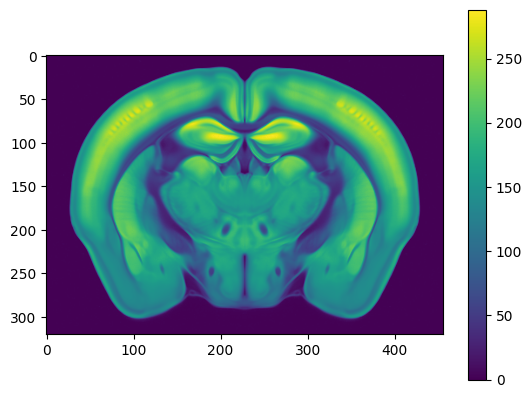

In [160]:

plt.imshow(reference_image[260])
plt.colorbar()

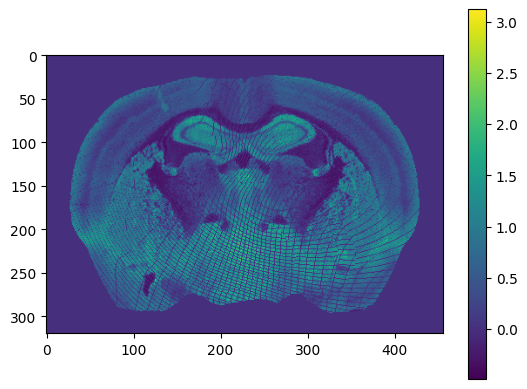

In [161]:
plt.imshow(volume[260])
plt.colorbar()

In [8]:
volume

tensor[528, 320, 456] f64 n=77045760 x∈[-0.643, 4.674] μ=0.003 σ=0.047

# Slices

In [8]:
import torch
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from torch.nn.functional import normalize

V = volume.clone().float()
mask = slices == 20

# Example setup: Let's assume V is your 3D volume tensor and mask is a boolean tensor of the same shape
# V.shape = (D, H, W), mask.shape = (D, H, W)
D, H, W = mask.shape
V = volume.clone()

# Step 1: Extract the coordinates of the masked points
coordinates = torch.nonzero(mask.permute(1, 2, 0), as_tuple=False).long()  # Shape: (N, 3), where N is the number of points
# coordinates = torch.cartesian_prod(torch.arange(D), torch.arange(H), torch.arange(W))
# coordinates = coordinates[mask.view(-1)]
# coordinates contains points as (z, y, x)

# Step 2: Fix one point as the origin
origin = coordinates[0].float()  # Choose the first point in the mask as the origin

# Step 3: Calculate the offsets by subtracting the origin
shifted_coordinates = coordinates - origin  # Shape: (N, 3)
shifted_coordinates = shifted_coordinates[1:]


In [75]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from PySide6.QtCore import Qt
# from PySide6.QtWidgets import QApplication, QLabel
%matplotlib qt

vectors = normalize(shifted_coordinates)

fig = plt.figure(figsize = (10, 10))
axes = plt.axes(projection = '3d')
plt.title("Dynamic Axes")

axes.scatter3D(0, 0, 0, s=20, alpha=0.7, color='r', marker="o")

axes.scatter3D(v[0], v[1], v[2], color='b', s=20)
axes.scatter3D(vectors[perm][:, 0], vectors[perm][:, 1], vectors[perm][:, 2], color=(0, 1, 1, 0.2), s=1)
axes.scatter3D(normals[:, 0], normals[:, 1], normals[:, 2], color='k', s=20)



plt.show()


In [74]:
vectors @ orthogonal

tensor[54720] x∈[-0.006, 0.689] μ=0.003 σ=0.009

In [73]:
num_pairs = len(shifted_coordinates)//2
random_perm = torch.randperm(len(shifted_coordinates))
normals = torch.cross(shifted_coordinates[random_perm][:num_pairs], shifted_coordinates[random_perm][num_pairs:2*num_pairs])
normals = normals[(normals.norm(dim=-1) >5000)]
normals = torch.abs(normalize(normals))
orthogonal = normalize(normals.mean(dim=0).unsqueeze(0))[0]
orthogonal, shifted_coordinates @ orthogonal


(tensor[3] x∈[0.004, 0.971] μ=0.405 σ=0.504 [0.240, 0.004, 0.971],
 tensor[54720] x∈[-1.486, 1.686] μ=0.189 σ=0.584)

In [268]:
orthogonal = normalize(orthogonal.unsqueeze(0))[0]
orthogonal

tensor[3] x∈[-0.655, 0.655] μ=-0.126 σ=0.690 [-0.377, 0.655, -0.655]

In [76]:
import torch
import torch.nn.functional as F
import numpy as np

def rotate_volume(V, p):
    # Step 1: Normalize the vector p
    p = p / torch.norm(p)

    # Step 2: Calculate the rotation axis and angle
    z_axis = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float)
    axis = torch.cross(p, z_axis)
    axis_norm = torch.norm(axis)

    # If the axis norm is zero, then p is already aligned with z-axis
    if axis_norm == 0:
        return V  # No rotation needed
    
    axis = axis / axis_norm  # Normalize the rotation axis
    angle = torch.acos(torch.dot(p, z_axis))  # Angle between p and z-axis

    # Step 3: Construct the rotation matrix using Rodrigues' rotation formula
    K = torch.tensor([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]], dtype=torch.float)

    I = torch.eye(3)
    R = I + torch.sin(angle) * K + (1 - torch.cos(angle)) * (K @ K)

    # Step 4: Apply the rotation to the volume V
    # Create a grid of coordinates representing the volume
    D, H, W = V.shape
    z, y, x = torch.meshgrid(
        torch.linspace(-1, 1, D), torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij'
    )
    coords = torch.stack([x, y, z], dim=-1).reshape(-1, 3)  # Shape: (D*H*W, 3)

    # Apply the rotation matrix to the coordinates
    rotated_coords = coords @ R.T

    # Reshape the rotated coordinates back to grid form and normalize to [-1, 1]
    rotated_coords = rotated_coords.reshape(D, H, W, 3)
    rotated_coords = rotated_coords.permute(3, 0, 1, 2)  # Shape: (3, D, H, W)

    # Normalize rotated coordinates to the range [-1, 1]
    rotated_coords[0] = rotated_coords[0] / torch.max(torch.abs(rotated_coords[0]))
    rotated_coords[1] = rotated_coords[1] / torch.max(torch.abs(rotated_coords[1]))
    rotated_coords[2] = rotated_coords[2] / torch.max(torch.abs(rotated_coords[2]))

    rotated_coords = rotated_coords.permute(1, 2, 3, 0).unsqueeze(0)  # Shape: (1, D, H, W, 3)

    # Reshape volume V for grid sampling
    V_reshaped = V.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, D, H, W)

    # Use grid_sample to interpolate the volume based on the rotated coordinates
    rotated_volume = F.grid_sample(V_reshaped, rotated_coords, align_corners=True, mode='bilinear')

    # Remove batch and channel dimensions
    return rotated_volume.squeeze()



In [77]:
masked_V = V.clone()
masked_V[~mask] *= 0.
rotated_V = rotate_volume(mask.float(), orthogonal)
print(rotated_V.shape)  # Should be the same shape as V: (D, H, W)

torch.Size([528, 320, 456])


In [134]:
# import napari
# import numpy as np

# viewer = napari.view_image(rotated_V.detach().numpy(), ndisplay=3)  # 'ndisplay=3' for 3D viewing


In [13]:
section = torch.tensor(np.load("data/sections/section10.npy"))
section

tensor[281, 421, 157] f64 n=18573257 x∈[-0.589, 280.000] μ=0.681 σ=10.734

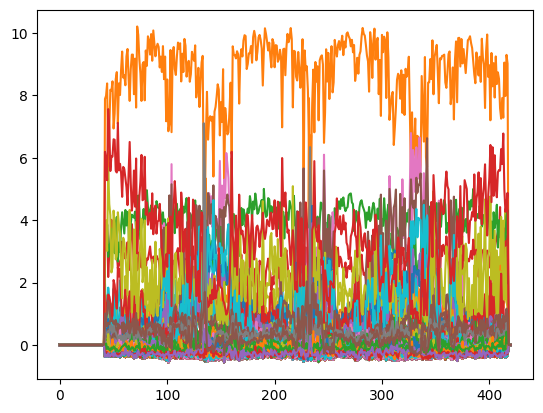

In [15]:
plt.plot(section[130][:, :-1])

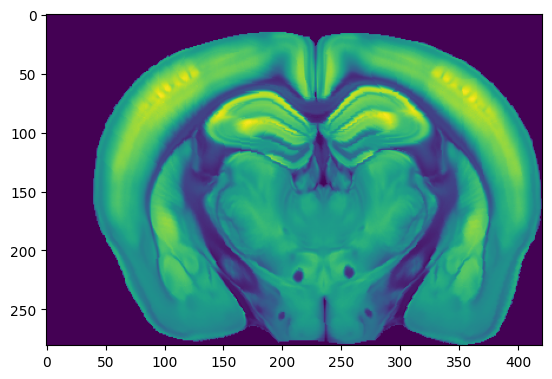

In [75]:
plt.imshow(section[:, :, -1])

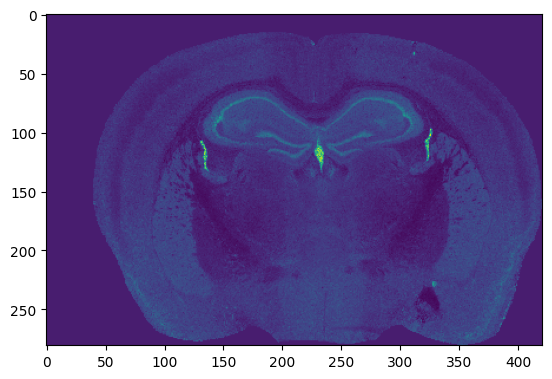

In [84]:
plt.imshow(section[:, :, -10])

# Dataset

In [4]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


In [5]:
def apply_circle_mask(img):
    W, H = img.shape[-2:]
    cp = torch.cartesian_prod(torch.arange(W, device=img.device), torch.arange(H, device=img.device))
    circle_mask = (cp[:, 0] - W / 2) ** 2 + (cp[:, 1] - W / 2) ** 2 <= (W / 2) ** 2
    return img * circle_mask.reshape(img.shape[-2:])

In [6]:
from mice.datasets.slice_dataset import SliceDataset
import lovely_tensors as lt
import os
lt.monkey_patch()

DATA_PATH = '/mydata/chip/shared/data' if torch.cuda.is_available() else 'data'

means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))


kwargs = {
    'path': 'data/sections',
    'im_size':32,
    'train_transform': True,
#     'rotation_angle': 30,
#     'rescale': 100,
    'stds':stds,
    'means':means
}

trainSet = SliceDataset(**kwargs)
print(trainSet[100])

tensor[2, 157, 32] n=10048 x∈[-1.862, 2.657] μ=0.046 σ=0.776


In [109]:
_, s = trainSet[0]
s

tensor[157, 32] n=5024 x∈[-1.675, 2.005] μ=0.824 σ=0.929

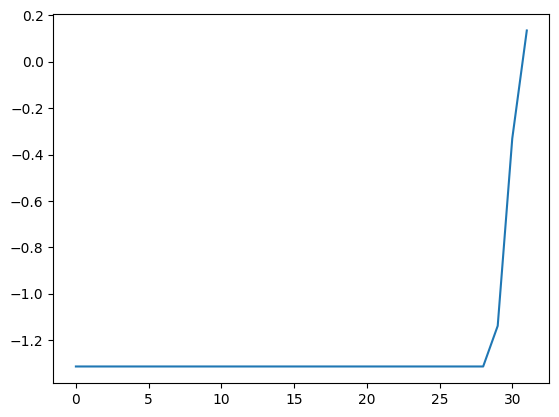

In [110]:
plt.plot(s[-1])

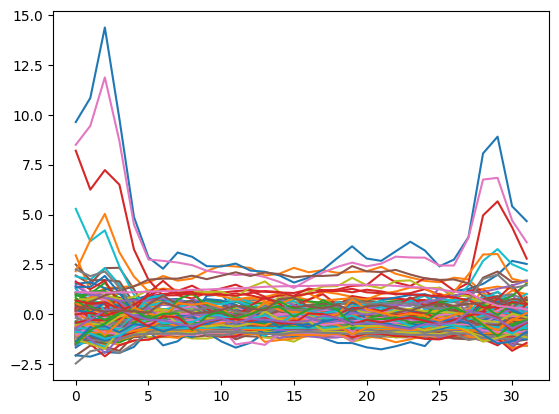

In [59]:
plt.plot(s.T)

# compute mean and std

In [ ]:
from tqdm.auto import tqdm
s_list = []
for _ in tqdm(range(10000)):
    s = trainSet[i]
    s_list.append(s)
samples = torch.stack(s_list)
samples

In [38]:
# np.save("stds", stds)
# np.save("means", means)

In [83]:
stds = []
means = []
flat_samples = samples.flatten(0, 1)
for i in range(157):
    stds.append(flat_samples[:, i].std())
    means.append(flat_samples[:, i].mean())
stds = torch.stack(stds)
means = torch.stack(means)

norm_samples = (flat_samples - means[None, :, None]) / stds[None, :, None]
norm_samples

tensor[10664, 157, 32] n=53575936 x∈[-5.662, 56.431] μ=8.816e-09 σ=1.000

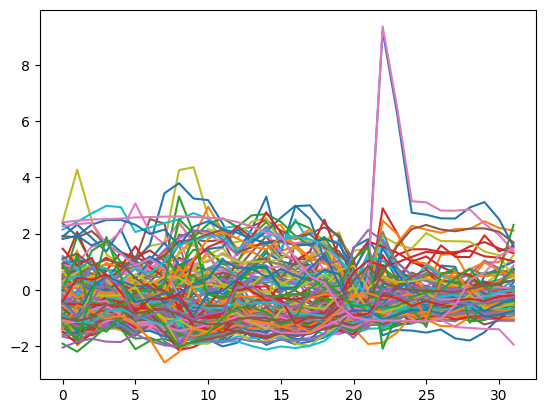

In [84]:
plt.plot(norm_samples[0].T)

# Testing Diffussion model

In [61]:
from diffusers import UNet1DModel
from main import load_model
device = torch.device('mps') if torch.backends.mps.is_built() else torch.device('mps')
model = UNet1DModel(
        sample_size=32,  # Adjusted to 32
        in_channels=157,
        out_channels=157,
        layers_per_block=1,
        block_out_channels=(32, 64),  # Reduced the number of output channels per block
        down_block_types=(
            "DownBlock1D",  # Keep the same
            "AttnDownBlock1D",  # One less downsampling block
        ),
        up_block_types=(
            "AttnUpBlock1D",  # Keep the same
            "UpBlock1D",  # Reduced the number of upsampling blocks accordingly
        ),
    ).to(device)
load_model(model, "checkpoints/MiceBrain.pt")
model.eval()
""

models loaded from checkpoint checkpoints/MiceBrain.pt


''

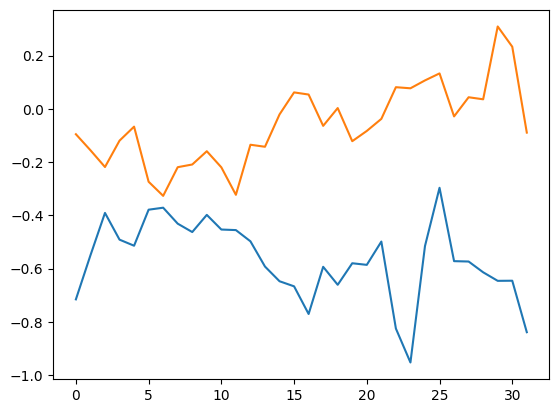

In [23]:
# load dataset
from main import get_dataset
means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))
kwargs = {
    "path": "data/sections",
    'im_size':32,
    "train_transform": True,
    'stds': stds,
    'means': means
}

trainSet, testSet = get_dataset(kwargs)
target = testSet[0][:1]
target
plt.plot(target[0, 0])
plt.plot(target[0, 100])

# Visualize reconstructions

In [128]:
res = torch.tensor(np.load("mice_recons.npy"))
res2 = torch.tensor(np.load("mice_recons2.npy"))
res

tensor[544, 320, 480, 11] n=919142400 x∈[-2.251, 525.242] μ=4.927 σ=28.214

In [143]:
import napari
import numpy as np

viewer = napari.view_image(res[:, :, :, 2].detach().numpy(), ndisplay=3)  # 'ndisplay=3' for 3D viewing
# viewer = napari.view_image(res2[:, :, :, channel].detach().numpy(), ndisplay=3)  # 'ndisplay=3' for 3D viewing


Traceback (most recent call last):
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 572, in closeEvent
    quit_app()
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/_qt/qt_event_loop.py", line 232, in quit_app
    v.close()
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/viewer.py", line 146, in close
    self.window.close()
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 1525, in close
    self._qt_viewer.close()
RuntimeError: wrapped C/C++ object of type QtViewer has been deleted


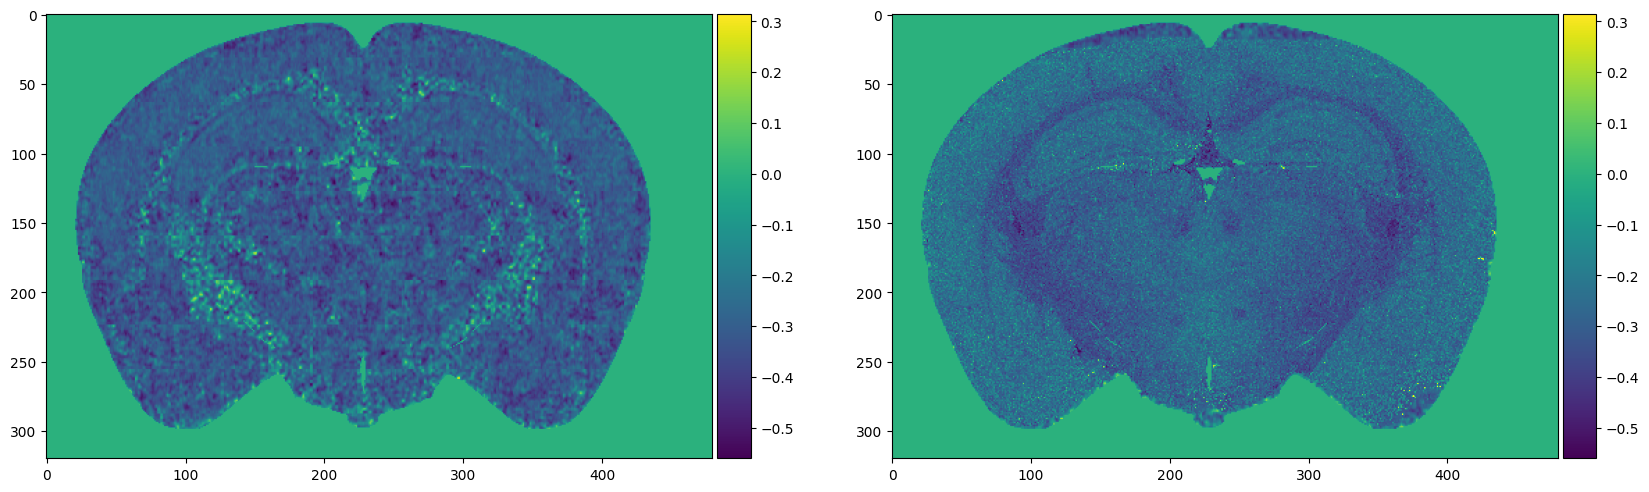

In [142]:
# slices 260, 300
slice_idx = 300
channel = -8
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

# Display images in subplots
slice1 = res[:, :, :, channel][slice_idx].cpu()
slice2 = res2[:, :, :, channel][slice_idx].cpu()
a = torch.min(torch.max(slice1), torch.max(slice2))
b = torch.max(torch.min(slice1), torch.min(slice2))
im1 = ax1.imshow(slice1, vmin = b.item(), vmax=a.item())
im2 = ax2.imshow(slice2, vmin = b.item(), vmax=a.item())

# Add smaller colorbars to each subplot
for ax, im in zip([ax1, ax2], [im1, im2]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust 'size' and 'pad' for custom sizing
    fig.colorbar(im, cax=cax)


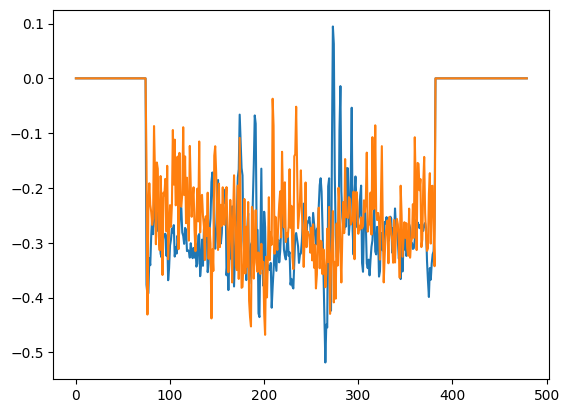

In [126]:
row = 50
plt.plot(slice1[row])
plt.plot(slice2[row])

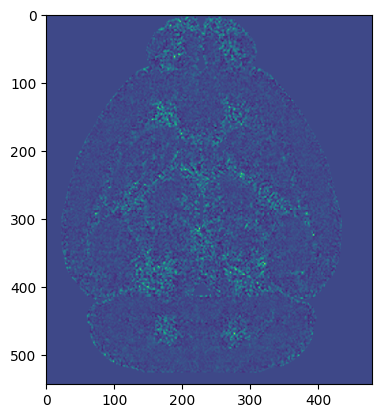

In [43]:
plt.imshow(res[:, :, :, -2][:, 130].cpu())

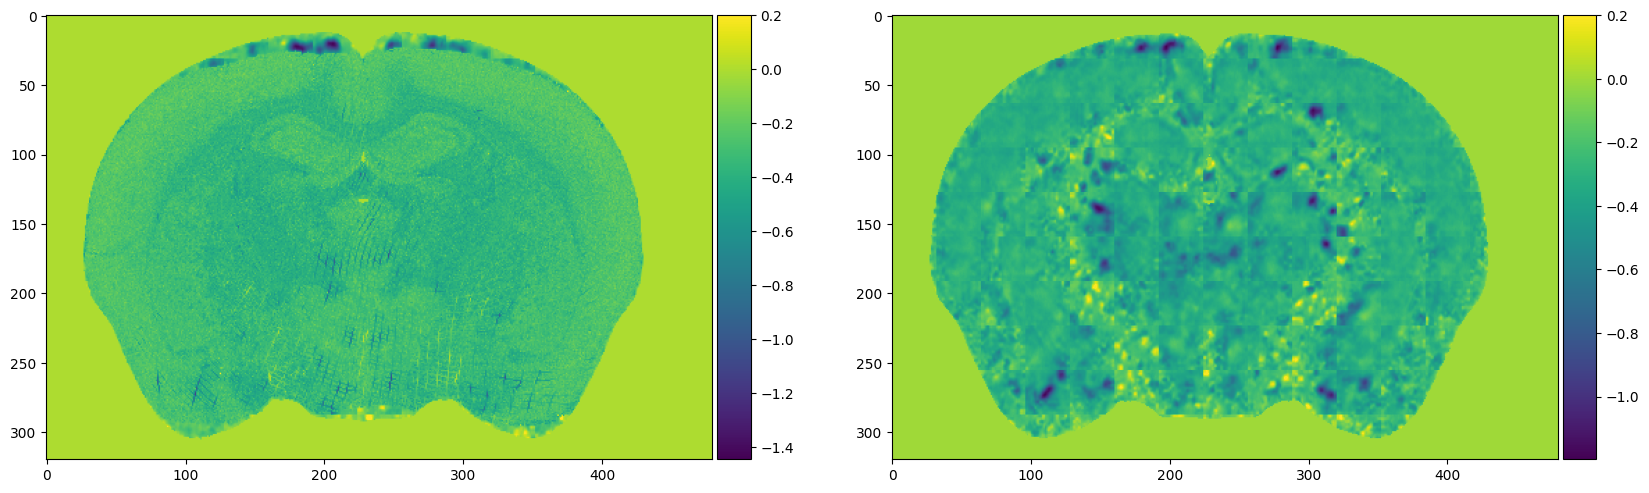

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
im1 = ax1.imshow(res[260, :, :, -8], vmax=0.2)
im2 = ax2.imshow(res[257, :, :, -8], vmax=0.2)

for ax, im in zip([ax1, ax2], [im1, im2]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust 'size' and 'pad' for custom sizing
    fig.colorbar(im, cax=cax)